In [ ]:
import re
from collections import Counter
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import random
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#path_train = '/content/drive/My Drive/results/'

Mounted at /content/drive


# Load dataset and explore it

In [ ]:
###
train_data['#'].describe()

count     254592
unique     29965
top            #
freq       14534
Name: #, dtype: object

In [ ]:
#function of the code below (use on training)
def load_dataset(path):
  data = pd.read_table(path, error_bad_lines=False, warn_bad_lines=False)
  # Remove the rows of the file that contain a "NaN" value.
  data.dropna() #if i remove this parameter it takes all the word (doesn't divide by phrases)
  return data

In [ ]:
def plot_labels_distribution(data):
  l = data['id'].value_counts()
  l = l.drop(["id", 'O'])
  print(l)
  #plt.xlim(40, 160)
  #plt.ylim(0, 0.03)
  plt.figure(figsize=(15,8))
  plt.plot(l, color = "skyblue")
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.title('Distribution of the labels')

  plt.grid(True)

def plot_50_top_words(data):
  l = data['#'].value_counts()
  l = l.head(50)
  #l = l.drop(["id", 'O'])
  #print(l)

  #plt.xlim(40, 160)
  #plt.ylim(0, 0.03)
  plt.figure(figsize=(30,10))
  plt.plot(l, color = "skyblue", label='Sine wave')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title('50 most frequent words')

  plt.grid(True)

In [ ]:
###
#copied by notebook nlp

import pandas as pd

# Load the data into a pandas "DataFrame" object.
train_data = pd.read_table('/content/drive/MyDrive/data (1)/train.tsv', error_bad_lines=False, warn_bad_lines=False)

# Remove the rows of the file that contain a "NaN" value.
train_data.dropna() #if i remove this parameter it takes all the word (doesn't divide by phrases)

# Let's see what the file contains (returns the first 5 rows by default).
train_data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,#,id,0
0,it,O,NaN
1,lies,O,NaN
2,approximately,O,NaN
3,north,O,NaN
4,east,O,NaN


I-GRP     6084
I-PER     5805
I-CW      5716
B-PER     5090
B-LOC     4556
B-CW      3551
B-GRP     3375
I-CORP    2987
B-CORP    2975
B-PROD    2770
I-LOC     2598
I-PROD    1710
Name: id, dtype: int64


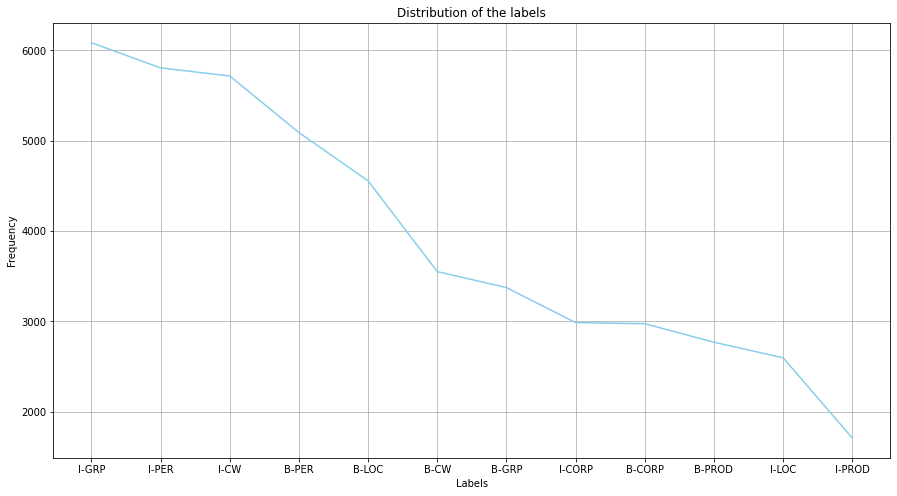

In [ ]:
l = train_data['id'].value_counts()
l = l.drop(["id", 'O'])
print(l)

#plt.xlim(40, 160)
#plt.ylim(0, 0.03)
plt.figure(figsize=(15,8))
plt.plot(l, color = "skyblue")
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of the labels')

plt.grid(True)
#plt.hist(l, color = "skyblue", ec="skyblue")

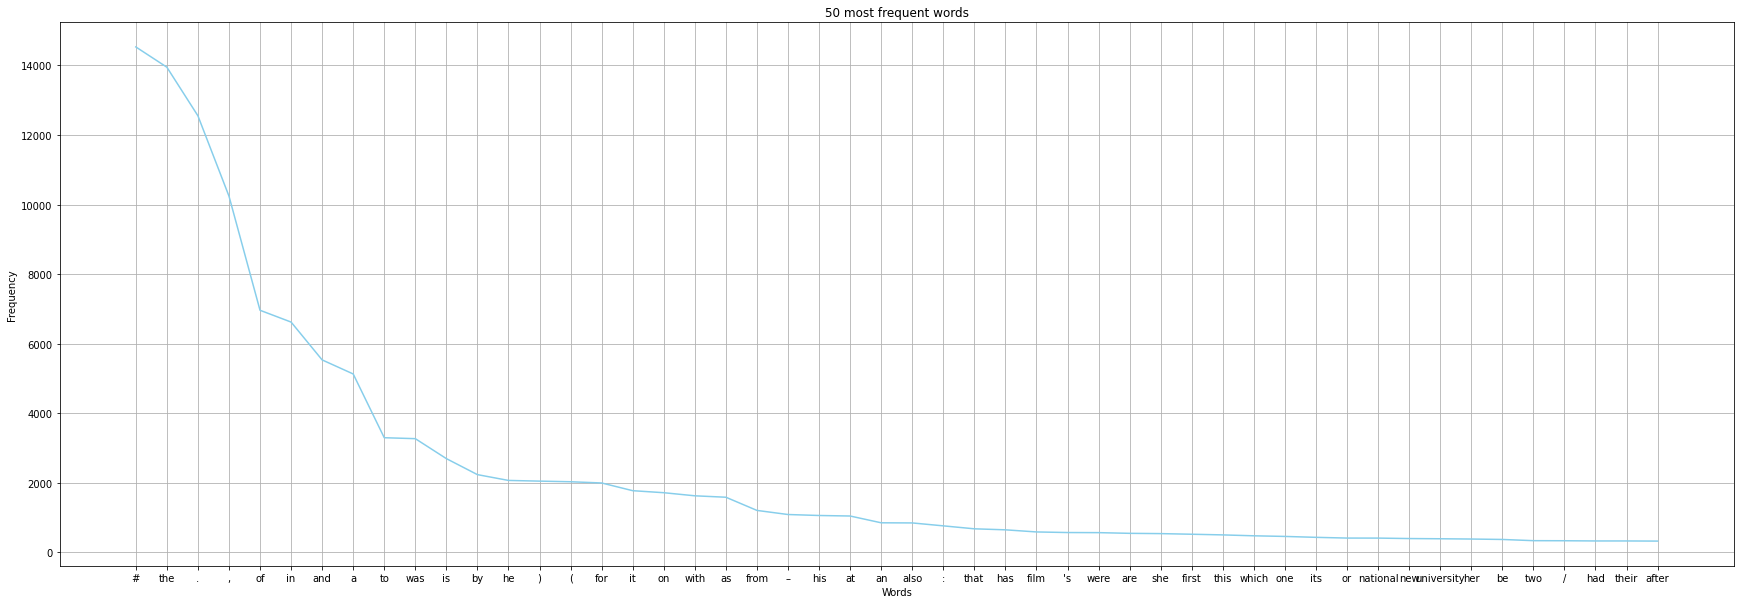

In [ ]:
#print the 50 most frequent words
l = train_data['#'].value_counts()
l = l.head(50)
#l = l.drop(["id", 'O'])
#print(l)

#plt.xlim(40, 160)
#plt.ylim(0, 0.03)
plt.figure(figsize=(30,10))
plt.plot(l, color = "skyblue", label='Sine wave')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('50 most frequent words')

plt.grid(True)
#plt.hist(l, color = "skyblue", ec="skyblue")

# Create dictionary

In [ ]:
#try with wiki-50 (is faster)

#load glove embeddings
import gensim.downloader as gen

wv = gen.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
#try with wiki-300

#load glove embeddings
import gensim.downloader as gen

wv = gen.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


KeyboardInterrupt: ignored

In [ ]:
#create a dictionary with all the words present on glove
words = wv.vocab

In [ ]:
#create a dictionary from glove: word to index and index to word

def default():
  dictionary_indices = {}
  dictionary_words = []
  dictionary_indices['pad'] = 0
  dictionary_words.append('pad')
  dictionary_indices['unk'] = 1
  dictionary_words.append('unk')

  return dictionary_indices, dictionary_words


def create_dictionary(wv):
  dictionary_indice, dictionary_words = default()
  for i in wv:
    #print(i)
    if i != 'unk' and i != 'pad':
      dictionary_indice[i] = len(dictionary_indice)
      dictionary_words.append(i)

  return dictionary_indice, dictionary_words


In [ ]:
word_to_indices, indices_to_word = create_dictionary(words)

In [ ]:
###
word_to_indices['good']

221

In [ ]:
###
indices_to_word

In [ ]:
#create index to label and label to index

label_to_indices = {'PAD' : 0, 'O' : 1, 'B-PER' : 2,'I-PER' : 3,'B-LOC' : 4,'I-LOC' : 5,'B-GRP' : 6,'I-GRP' : 7,'B-CORP' : 8,'I-CORP' : 9,'B-PROD' : 10,'I-PROD' : 11,'B-CW' : 12,'I-CW' : 13}
indices_to_label = ['PAD', 'O', 'B-PER' ,'I-PER' ,'B-LOC' ,'I-LOC' ,'B-GRP' ,'I-GRP' ,'B-CORP' ,'I-CORP' ,'B-PROD' ,'I-PROD' ,'B-CW' ,'I-CW']

# Encode dataset

In [ ]:
#convert dataset into a dictionary and count max words per phrase
def create_list(train_data):
  c = 0
  n_word = 0
  max = 0
  lista_train= {}
  lista = []
  for i in range(0, len(train_data)):
    if(train_data['#'][i] == '#'):
      lista_train[c] = lista
      if max < n_word:
        max = n_word
      lista = []
      n_word = 0
      c += 1
    else:
      lista.append([train_data['#'][i], train_data['id'][i]])
      n_word += 1

  return lista_train, max

In [ ]:
###
lista_train, max = create_list(train_data)

In [ ]:
type(lista_train)

dict

In [ ]:
#transform data so each phrase has the same length
def all_same_length(train, max):
  for i in train:
    diff = max - len(train[i]) 
    if diff > 0:
      for x in range(0, diff):
        train[i].append(['pad', 'PAD'])

  return train

In [ ]:
#questo metodo fa tutte le singole scritte (lo chiamo nel training)
def dataset_creator(data, word_to_indices, label_to_indices):
  lista, max = create_list(data)
  same_length = all_same_length(lista, max)
  word_indices = dataset_to_indices(same_length, word_to_indices)
  label_ind, count_classes = label_index(same_length, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, count_classes

In [ ]:
###
train_same_length = all_same_length(lista_train, max)

In [ ]:
###
print(train_same_length[0])
print(max)

[['it', 'O'], ['lies', 'O'], ['approximately', 'O'], ['north', 'O'], ['east', 'O'], ['of', 'O'], ['bolesławiec', 'B-LOC'], [',', 'O'], ['and', 'O'], ['west', 'O'], ['of', 'O'], ['the', 'O'], ['regional', 'O'], ['capital', 'O'], ['wrocław', 'B-LOC'], ['.', 'O'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD'], ['pad', 'PAD']]
41


In [ ]:
#Word into indices using vocabolary just create

def dataset_to_indices(lista_train, w):
  word_indices = {}
  c = 0

  for i in lista_train:
    indices = []
    for j in lista_train[i]:
      #print(j[1])
      try:
        indices.append(w[j[0]])
      except:
        indices.append(1) #if the word isn't on dictionary
    word_indices[c] = indices
    c += 1
  return word_indices


In [ ]:
###
word_indices = dataset_to_indices(train_same_length, word_to_indices)

In [ ]:
###
word_indices[1]

In [ ]:
#label to index
def label_index(lista_train, l):
  word_label = {}
  a = {'PAD' : 0, 'O' : 0, 'B-PER' : 0,'I-PER' : 0,'B-LOC' : 0,'I-LOC' : 0,'B-GRP' : 0,'I-GRP' : 0,'B-CORP' : 0,'I-CORP' : 0,'B-PROD' : 0,'I-PROD' : 0,'B-CW' : 0,'I-CW' : 0}
  c = 0

  for i in lista_train:
    label = []
    for j in lista_train[i]:
      #print(j[1])
      label.append(l[j[1]])
      a[j[1]] += 1
    word_label[c] = label
    c += 1
  return word_label, a


In [ ]:
###
label_ind_training = label_index(train_same_length, label_to_indices)

In [ ]:
###
len(label_ind_training)

14534

In [ ]:
###
print(label_ind_training[1])

[11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Try example

In [ ]:
###
#try to embed with pytorch (made by them, but adapted)
#transform all phrases on vector with the same length (10)

embedding_layer = nn.Embedding(len(word_to_indices), 10)
print(embedding_layer)
x_embeddings = embedding_layer(torch.LongTensor(word_indices[0]))
print(x_embeddings.shape)
print(x_embeddings[0])
print(x_embeddings[0].detach().numpy())
print(x_embeddings[0].tolist())

Embedding(400000, 10)
torch.Size([41, 10])
tensor([-1.8976,  0.0375, -2.7222,  0.8282,  0.3488, -0.3006, -1.4327, -0.6987,
         0.3991, -0.9670], grad_fn=<SelectBackward0>)
[-1.8975549   0.03754022 -2.7222123   0.8281561   0.3488142  -0.30064598
 -1.4326546  -0.6986831   0.3991374  -0.96700877]
[-1.897554874420166, 0.037540219724178314, -2.722212314605713, 0.8281561136245728, 0.3488141894340515, -0.30064597725868225, -1.432654619216919, -0.6986830830574036, 0.399137407541275, -0.9670087695121765]


In [ ]:
###
lstm = nn.LSTM(10, 5) # sequence length and hidden dimensions
lstm

LSTM(10, 5)

In [ ]:
###
print("x_embeddings.shape =", x_embeddings.shape)
batched_x_embeddings = x_embeddings.unsqueeze(1) # adding the batch dimension (with 1 element)
print("batched_x_embeddings.shape =",batched_x_embeddings.shape)
o, (h, c) = lstm(batched_x_embeddings)

print("o.shape =", o.shape)
o = o.squeeze() # removing the batch dimension with one element only
print("o.shape =", o.shape)
print("x_embeddings.shape =", x_embeddings.shape)
print(o[3].detach().numpy()) # detach disconnects the tensor from the computation graph
print(x_embeddings[3].detach().numpy())

x_embeddings.shape = torch.Size([41, 10])
batched_x_embeddings.shape = torch.Size([41, 1, 10])
o.shape = torch.Size([41, 1, 5])
o.shape = torch.Size([41, 5])
x_embeddings.shape = torch.Size([41, 10])
[0.05411072 0.02916004 0.13606599 0.06811907 0.35106528]
[ 0.80763346  0.80125624 -0.04134348  1.1182485   0.6730789  -0.6136849
 -1.4124391  -1.525016   -0.6530907   2.2377603 ]


In [ ]:
###
h

tensor([[[ 0.7380,  0.3503, -0.1526, -0.3178, -0.4165]]],
       grad_fn=<StackBackward0>)

In [ ]:
###
classifier = nn.Linear(5, len(indices_to_label)) 
classifier

Linear(in_features=5, out_features=14, bias=True)

In [ ]:
###
output = classifier(o)
print("output.shape =", output.shape)
print(output)

output.shape = torch.Size([41, 14])
tensor([[-0.2779, -0.2319, -0.2223, -0.4507,  0.1513, -0.0276,  0.2003,  0.1500,
          0.0302, -0.3189, -0.5023,  0.1075,  0.2007, -0.1875],
        [-0.1346, -0.0342, -0.2317, -0.5664,  0.0684, -0.1403,  0.1279,  0.1970,
         -0.0111, -0.5292, -0.3387,  0.1735,  0.2443, -0.4725],
        [-0.2293, -0.1684, -0.4380, -0.4737, -0.1950, -0.1774, -0.0805,  0.2631,
          0.1466, -0.3953, -0.3724, -0.0567,  0.1317, -0.1968],
        [-0.4342, -0.2166, -0.4272, -0.4144, -0.0062, -0.0671, -0.0371,  0.1254,
         -0.0554, -0.4452, -0.3411, -0.1684,  0.0420, -0.3569],
        [-0.3472, -0.0501, -0.5384, -0.4108, -0.1653, -0.1339, -0.1518,  0.1720,
         -0.0216, -0.4690, -0.1524, -0.2668, -0.0758, -0.5161],
        [-0.2536,  0.0159, -0.5453, -0.4507, -0.2450, -0.1878, -0.1794,  0.2349,
          0.0615, -0.4664, -0.1312, -0.2495, -0.0506, -0.5153],
        [-0.2190, -0.1026, -0.3507, -0.4499, -0.0151, -0.1054,  0.0568,  0.1727,
         -0.0

In [ ]:
###
#assign results
print(output)
top_label_scores, top_label_indices = torch.max(output, -1)

top_label_indices = top_label_indices.tolist()
print('indices_assigned: ', top_label_indices, 'lunghezza: ', len(top_label_indices))
print('indices_correct: ', label_ind_training[0], 'lunghezza: ', len(label_ind_training[0]))
print('score: ', top_label_scores)

k = 0
for i in top_label_indices:
  print('label_assigned: ', indices_to_label[i])
  print('label_correct: ', indices_to_label[label_ind_training[0][k]])
  k += 1

tensor([[-0.2779, -0.2319, -0.2223, -0.4507,  0.1513, -0.0276,  0.2003,  0.1500,
          0.0302, -0.3189, -0.5023,  0.1075,  0.2007, -0.1875],
        [-0.1346, -0.0342, -0.2317, -0.5664,  0.0684, -0.1403,  0.1279,  0.1970,
         -0.0111, -0.5292, -0.3387,  0.1735,  0.2443, -0.4725],
        [-0.2293, -0.1684, -0.4380, -0.4737, -0.1950, -0.1774, -0.0805,  0.2631,
          0.1466, -0.3953, -0.3724, -0.0567,  0.1317, -0.1968],
        [-0.4342, -0.2166, -0.4272, -0.4144, -0.0062, -0.0671, -0.0371,  0.1254,
         -0.0554, -0.4452, -0.3411, -0.1684,  0.0420, -0.3569],
        [-0.3472, -0.0501, -0.5384, -0.4108, -0.1653, -0.1339, -0.1518,  0.1720,
         -0.0216, -0.4690, -0.1524, -0.2668, -0.0758, -0.5161],
        [-0.2536,  0.0159, -0.5453, -0.4507, -0.2450, -0.1878, -0.1794,  0.2349,
          0.0615, -0.4664, -0.1312, -0.2495, -0.0506, -0.5153],
        [-0.2190, -0.1026, -0.3507, -0.4499, -0.0151, -0.1054,  0.0568,  0.1727,
         -0.0029, -0.4202, -0.3070,  0.0438,  0.1

# Build model

In [ ]:
class ClassifierModel(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(ClassifierModel, self).__init__()
        # Embedding layer: a mat∂rix vocab_size x embedding_dim where each index 
        # correspond to a word in the vocabulary and the i-th row corresponds to 
        # a latent representation of the i-th word in the vocabulary.
        print(params)
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings is not None:
            print("initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams.embeddings)

        # LSTM layer: an LSTM neural network that process the input text
        # (encoded with word embeddings) from left to right and outputs 
        # a new **contextual** representation of each word that depend
        # on the preciding words.
        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0)
        # Hidden layer: transforms the input value/scalar into
        # a hidden vector representation.
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2

        # During training, randomly zeroes some of the elements of the 
        # input tensor with probability hparams.dropout using samples 
        # from a Bernoulli distribution. Each channel will be zeroed out 
        # independently on every forward call.
        # This has proven to be an effective technique for regularization and 
        # preventing the co-adaptation of neurons
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)

    
    def forward(self, x):
        embeddings = self.word_embedding(x)
        print('INPUT: ', embeddings.size())
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        output = self.classifier(o)
        return output

        

In [ ]:
class HParams():
    vocab_size = len(word_to_indices)
    hidden_dim = 128
    embedding_dim = 100
    num_classes = len(indices_to_label)
    bidirectional = True
    num_layers = 3
    dropout = 0.05
    embeddings = None
params = HParams()

In [ ]:
###
postagger = ClassifierModel(params)#.cuda()
postagger

ClassifierModel(
  (word_embedding): Embedding(400000, 100)
  (lstm): LSTM(100, 128)
  (dropout): Dropout(p=0.0, inplace=False)
  (classifier): Linear(in_features=128, out_features=14, bias=True)
)

In [ ]:
###
len(word_to_indices)

400000

In [ ]:
###
# the first 10 sentences
lista_10 = []
count = 0
for i in word_indices:
  count += 1
  #print(word_indices[i])
  lista_10.append(torch.LongTensor(word_indices[i]))
  if count > 9:
    break


encoded_input = lista_10
logits = postagger(torch.stack(encoded_input, 0))#.cuda())

top_label_scores, top_label_indices = torch.max(logits, -1)
top_label_indices = top_label_indices.tolist()

In [ ]:
###
for i in range(0, len(top_label_indices)):
    print('predicted labels: ', top_label_indices[i])
    print('correct labels: ', label_ind_training[i])
    print('--------------------------------------------------------------------------')


predicted labels:  [3, 9, 11, 6, 7, 6, 6, 11, 7, 1, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
correct labels:  [13, 13, 13, 13, 13, 13, 3, 13, 13, 13, 13, 13, 13, 13, 3, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------------------------------
predicted labels:  [3, 7, 6, 7, 3, 3, 3, 1, 7, 3, 3, 7, 11, 6, 6, 2, 3, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
correct labels:  [11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------------------------------------------------------------
predicted labels:  [7, 10, 6, 7, 7, 11, 6, 6, 11, 1, 7, 11, 5, 6, 6, 7, 7, 7, 3, 6, 6, 6, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
correct labels:  [1, 2, 13, 1, 2, 13, 1, 2, 13, 1, 2, 13, 1, 2, 13, 1, 2, 13, 1, 2, 13, 13, 13, 1

# Testset (try)

In [ ]:
prediction = [['I', 'was', 'running', 'on', 'a', 'beach', 'of', 'Florida', 'State'],
['I', 'am', 'in', 'Los', 'Angeles'],
['On', 'Mountain', 'View', 'there', 'is', 'Google'],
['There', 'is', 'only', 'one', 'Michael', 'Jordan'],
['I', 'think', 'Kobe', 'was', 'the', 'greatest', 'Lakers', 'ever'],
['The', 'Bic', 'is', 'famous', 'for', 'pens'],
['Pasta', 'is', 'very', 'good', 'in', 'Italy'],
['Cassius', 'Marcellus', 'Clay', 'Jr', 'was', 'the', 'greatest', 'boxer', 'ever'],
['Yesterday', ',', 'it', 'was', 'raining', 'in', 'London', '.', 'Like', 'usual']]

In [ ]:
#transform data so each phrase has the same length
def all_same_length_prediction(train, max):
  for i in range(0, len(train)):
    diff = max - len(train[i]) 
    if diff > 0:
      for x in range(0, diff):
        train[i].append('pad')

  return train

In [ ]:
prediction = all_same_length_prediction(prediction, 10)

In [ ]:
prediction

In [ ]:
def dataset_to_indices_prediction(lista_train, w):
  word_indices = {}
  c = 0

  for i in lista_train:
    indices = []
    for j in i:
      j = j.lower()
      try:
        indices.append(w[j])
      except:
        indices.append(1) #if the word isn't on dictionary
    word_indices[c] = indices
    c += 1
  return word_indices

In [ ]:
prediction = dataset_to_indices_prediction(prediction, word_to_indices)

NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE
NUOVA FRASE


In [ ]:
prediction

{0: [43, 17, 799, 15, 9, 1499, 5, 952, 94, 0],
 1: [43, 915, 8, 798, 932, 0, 0, 0, 0, 0],
 2: [15, 1613, 1141, 65, 16, 4363, 0, 0, 0, 0],
 3: [65, 16, 93, 50, 787, 1752, 0, 0, 0, 0],
 4: [43, 271, 9481, 17, 2, 2607, 4388, 663, 0, 0],
 5: [2, 62527, 16, 1615, 12, 19999, 0, 0, 0, 0],
 6: [12618, 16, 193, 221, 8, 933, 0, 0, 0, 0],
 7: [45059, 44499, 4922, 16660, 17, 2, 2607, 8094, 663, 0],
 8: [2859, 3, 22, 17, 24151, 8, 518, 4, 119, 3520]}

In [ ]:
pred = {}
c = 0
for i in prediction:
  lista_pred = []
  for j in prediction[i]: 
    lista_pred.append(torch.LongTensor(j))
  pred[c] = lista_pred
  c += 1

In [ ]:
pred

In [ ]:
test = {'1':[['I', 'O'], ['was', 'O'], ['running', 'O'], ['on', 'O'], ['a', 'O'], ['beach', 'O'], ['of', 'O'], ['Florida', 'B-LOC'], ['State', 'I-LOC']],
'2' : [['I', 'O'], ['am', 'O'], ['in', 'O'], ['Los', 'B-LOC'], ['Angeles', 'I-LOC']],
'3' : [['On', 'O'], ['Mountain', 'B-LOC'], ['View', 'I-LOC'], ['there', 'O'], ['is', 'O'], ['Google', 'B-CORP']],
'4' : [['There', 'O'], ['is', 'O'], ['only', 'O'], ['one', 'O'], ['Michael', 'B-PER'], ['Jordan', 'I-PER']],
'5' : [['I', 'O'], ['think', 'O'], ['Kobe', 'B-PER'], ['was', 'O'], ['the', 'O'], ['greatest', 'O'], ['Lakers', 'B-GRP'], ['ever', 'O']],
'6' : [['The', 'O'], ['Bic', 'B-CORP'], ['is', 'O'], ['famous', 'O'], ['for', 'O'], ['pens', 'B-PROD']],
'7' :[['Pasta', 'B-PROD'], ['is', 'O'], ['very', 'O'], ['good', 'O'], ['in', 'O'], ['Italy', 'B-LOC']],
'8' : [['Cassius', 'B-PER'], ['Marcellus', 'I-PER'], ['Clay', 'I-PER'], ['Jr', 'I-PER'], ['was', 'O'], ['the', 'O'], ['greatest', 'O'], ['boxer', 'O'], ['ever', 'O']],
'9' : [['Yesterday', 'O'], [',', 'O'], ['it', 'O'], ['was', 'O'], ['raining', 'O'], ['in', 'O'], ['London', 'B-LOC'], ['.', 'O'], ['Like', 'O'], ['usual', 'O']]}

In [ ]:
def test_creator(data, word_to_indices, label_to_indices):
  #lista, max = create_list(data)
  same_length = all_same_length(data, 10)
  word_indices = dataset_to_indices(same_length, word_to_indices)
  label_ind = label_index(same_length, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data

In [ ]:
test_data = test_creator(test, word_to_indices, label_to_indices)

TypeError: ignored

# Training

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        loss_function,
        optimizer,
        label_vocab: indices_to_label,
        log_steps:int=10_000,
        log_level:int=2):
        """
        Args:
            model: the model we want to train.
            loss_function: the loss_function to minimize.
            optimizer: the optimizer used to minimize the loss_function.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer

        self.label_vocab = label_vocab
        self.log_steps = log_steps
        self.log_level = log_level
        #self.label_vocab = label_vocab

    def train(self, train_dataset, 
              valid_dataset, 
              epochs:int=1):
        """
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing
                the training instances.
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                # labels  [[1,2,3], [18, 12, 3]] after the view(-1) [1,2,3, 18, 12, 3]
                
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss = self.evaluate(valid_dataset)
            
            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))

        if self.log_level > 0:
            print('... Done!')
        
        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss
    

    def evaluate(self, valid_dataset):
        """
        Args:
            valid_dataset: the dataset to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                print('LABRLS: ', labels.tolist())
                top_label_scores, top_label_indices = torch.max(predictions, -1)
                top_label_indices = top_label_indices.tolist()
                print('PREDICTION: ', top_label_indices)
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()
        
        return valid_loss / len(valid_dataset)

    def predict(self, x):
        """
        Args:
            x: a tensor of indices.
        Returns: 
            A list containing the predicted POS tag for each token in the
            input sentences.
        """
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits, -1)
            return logits, predictions
    
    

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
#window_size, window_shift = 100, 100
#device = "cuda"
training_data = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
dev_data = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')
trainingset = dataset_creator(training_data, word_to_indices, label_to_indices)
devset = dataset_creator(dev_data, word_to_indices, label_to_indices)
#testset = POSTaggingDataset(test_file, window_size, window_shift, device=device)

#trainingset.index_dataset(vocabulary, label_vocabulary)
#devset.index_dataset(vocabulary, label_vocabulary)
#testset.index_dataset(vocabulary, label_vocabulary)

train_dataset = DataLoader(trainingset, batch_size=128, shuffle=True)
valid_dataset = DataLoader(devset, batch_size=128, shuffle=False)
#test_dataset = DataLoader(testset, batch_size=128, shuffle=False)

classifier = ClassifierModel(params)#.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


In [ ]:
lstm_singol = Trainer(
    model = classifier,
    loss_function = nn.CrossEntropyLoss(ignore_index=label_to_indices['PAD']),
    optimizer = optim.Adam(classifier.parameters()),
    label_vocab=indices_to_label
)

In [ ]:
lstm_singol.train(train_dataset, valid_dataset, 2)

Training ...
 Epoch 001
INPUT:  tensor([[[-6.0386e-01, -6.6143e-02, -4.0672e-01,  ..., -4.8361e-01,
           4.4191e-01, -1.0129e+00],
         [-1.7906e+00, -3.0828e-01, -1.0645e+00,  ...,  3.0618e-01,
          -8.4928e-01,  7.2478e-01],
         [ 2.0122e-01, -5.8035e-01, -6.6098e-01,  ...,  7.2630e-01,
          -2.5641e-01,  2.7650e+00],
         ...,
         [ 2.4828e-02, -7.8006e-01, -9.7991e-01,  ...,  9.6870e-02,
           1.5476e-01,  3.4461e-01],
         [ 2.4828e-02, -7.8006e-01, -9.7991e-01,  ...,  9.6870e-02,
           1.5476e-01,  3.4461e-01],
         [ 2.4828e-02, -7.8006e-01, -9.7991e-01,  ...,  9.6870e-02,
           1.5476e-01,  3.4461e-01]],

        [[-1.8539e-01,  2.0697e-02, -6.4129e-01,  ...,  1.0500e+00,
          -5.8005e-01,  2.1595e-01],
         [ 1.0898e+00,  5.9133e-01, -1.6202e-01,  ...,  1.1750e+00,
           2.2873e-01, -1.3666e+00],
         [-1.7906e+00, -3.0828e-01, -1.0645e+00,  ...,  3.0618e-01,
          -8.4928e-01,  7.2478e-01],
       

KeyboardInterrupt: ignored

In [ ]:
test_dataset = DataLoader(test_data, batch_size=128, shuffle=False)
lstm_singol.evaluate(test_dataset)

NameError: ignored

# Bi directional LSTM

In [ ]:
params.bidirectional=True
params.num_layers=2

In [ ]:
bilstm_classifier = ClassifierModel(params)#.cuda()

In [ ]:
bilstm_trainer = Trainer(
    model = bilstm_classifier,
    loss_function = nn.CrossEntropyLoss(ignore_index=label_to_indices['PAD']),
    optimizer = optim.Adam(bilstm_classifier.parameters()),
    label_vocab=indices_to_label
)

In [ ]:
bilstm_trainer.train(train_dataset, valid_dataset, 2)

In [ ]:
test_dataset = DataLoader(test_data, batch_size=128, shuffle=False)
bilstm_trainer.evaluate(test_dataset)

LABRLS:  [13, 13, 13, 13, 13, 13, 13, 3, 4, 0, 13, 13, 13, 3, 4, 0, 0, 0, 0, 0, 13, 3, 4, 13, 13, 7, 0, 0, 0, 0, 13, 13, 13, 13, 1, 2, 0, 0, 0, 0, 13, 13, 1, 13, 13, 13, 5, 13, 0, 0, 13, 7, 13, 13, 13, 9, 0, 0, 0, 0, 9, 13, 13, 13, 13, 3, 0, 0, 0, 0, 1, 2, 2, 2, 13, 13, 13, 13, 13, 0, 13, 13, 13, 13, 13, 13, 3, 13, 13, 13]
PREDICTION:  [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


1.123106837272644

# Save and Load model

In [ ]:
#save
torch.save(model, PATH)

In [ ]:
#load
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()

# LSTM without stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords

list_punct = [',', '!', '?', '"', '.', ';', ':', '-', '_', '|', '\'', '/', '%', '&', '#', '+', '*', '^', '$', '(', ')', '[', ']', '{', '}', '<', '>', '=']

nltk.download('stopwords')
nltk.download('punkt')
print(stopwords.words('english')) #print stop words

for i in stopwords.words('english'):
  list_punct.append(i)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

In [ ]:
#dataset
def remove_stopwords(data):
  max = 0
  for i in data:
    length = 0
    for j in data[i]:
      length += 1
      if j[0] in list_punct:
        data[i].pop(length - 1)
    if max < length:
      max = length
  return data, max

In [ ]:
lista[0]

[['lies', 'O'],
 ['approximately', 'O'],
 ['north', 'O'],
 ['east', 'O'],
 ['bolesławiec', 'B-LOC'],
 ['west', 'O'],
 ['regional', 'O'],
 ['capital', 'O'],
 ['wrocław', 'B-LOC']]

In [ ]:
def dataset_creator_stopwords(data, word_to_indices, label_to_indices):
  lista, max = create_list(data)
  lista, max = remove_stopwords(lista)
  print(max)
  lista, max = remove_stopwords(lista)
  print(max)
  same_length = all_same_length(lista, max)
  word_indices = dataset_to_indices(same_length, word_to_indices)
  label_ind = label_index(same_length, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data

In [ ]:
train_dataset_stopwords[0]

{'inputs': tensor([  2347,   2129,    195,    324, 149550,    261,    912,    353,  32378,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0]),
 'outputs': tensor([13, 13, 13, 13,  3, 13, 13, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0])}

In [ ]:
#model

from torch.utils.data import DataLoader
import torch.optim as optim
#window_size, window_shift = 100, 100
#device = "cuda"

training_data_stopword = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
dev_data_stopwords = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')

train_dataset_stopwords = dataset_creator_stopwords(training_data_stopword, word_to_indices, label_to_indices)

devset_stopwords = dataset_creator_stopwords(dev_data_stopwords, word_to_indices, label_to_indices)
#testset = POSTaggingDataset(test_file, window_size, window_shift, device=device)

#trainingset.index_dataset(vocabulary, label_vocabulary)
#devset.index_dataset(vocabulary, label_vocabulary)
#testset.index_dataset(vocabulary, label_vocabulary)

train_dataset_stopwords = DataLoader(train_dataset_stopwords, batch_size=128, shuffle=True)
valid_dataset_stopwords = DataLoader(devset_stopwords, batch_size=128, shuffle=False)
#test_dataset = DataLoader(testset, batch_size=128, shuffle=False)

classifier_stopwords = ClassifierModel(params)#.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  if __name__ == '__main__':


30
28
25
21


In [ ]:
trainer = Trainer(
    model = classifier_stopwords,
    loss_function = nn.CrossEntropyLoss(ignore_index=label_to_indices['PAD']),
    optimizer = optim.Adam(classifier_stopwords.parameters()),
    label_vocab=indices_to_label
)

In [ ]:
trainer.train(train_dataset_stopwords, valid_dataset_stopwords, 10)

Training ...
 Epoch 001
	[E:  0] train loss = 1.5786
  [E:  0] valid loss = 1.4099
 Epoch 002
	[E:  1] train loss = 1.3585
  [E:  1] valid loss = 1.3157
 Epoch 003
	[E:  2] train loss = 1.2484
  [E:  2] valid loss = 1.2243
 Epoch 004
	[E:  3] train loss = 1.1534
  [E:  3] valid loss = 1.1693
 Epoch 005
	[E:  4] train loss = 1.0748
  [E:  4] valid loss = 1.1273
 Epoch 006
	[E:  5] train loss = 1.0092
  [E:  5] valid loss = 1.0946
 Epoch 007
	[E:  6] train loss = 0.9542
  [E:  6] valid loss = 1.0812
 Epoch 008
	[E:  7] train loss = 0.9046
  [E:  7] valid loss = 1.0680
 Epoch 009
	[E:  8] train loss = 0.8630
  [E:  8] valid loss = 1.0584
 Epoch 010
	[E:  9] train loss = 0.8225
  [E:  9] valid loss = 1.0563
... Done!


1.0967298052812877

# CNN with embeds

In [ ]:
training_data = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
lista, max = create_list(training_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """Entry point for launching an IPython kernel.


In [ ]:
def emebd_words(data):
  dic = {}
  unk = wv['unk']
  unk = torch.from_numpy(unk)
  for i in data:
    lista = []
    for j in data[i]:
      try:
        e = wv[j[0]]
        t = torch.from_numpy(e)
        lista.append([t, j[1]])
      except:
        lista.append([unk, j[1]])
    dic[i] = lista
  return dic

In [ ]:
embeds = emebd_words(lista)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  after removing the cwd from sys.path.


In [ ]:
def all_same_length_embeds(train, max):
  pad = torch.zeros(300)
  for i in train:
    diff = max - len(train[i]) 
    if diff > 0:
      for x in range(0, diff):
        train[i].append([pad, 'PAD'])

  return train

In [ ]:
embeds = all_same_length_embeds(embeds, max)

In [ ]:
def dataset_to_embeds(lista_train):
  dic = {}
  c = 0

  for i in lista_train:
    lista = []
    for j in lista_train[i]:
      lista.append(j[0])
    dic[c] = lista
    c += 1
  return dic

In [ ]:
label_to_indices_cnn = {'PAD' : -100, 'B-PER' : 1,'I-PER' : 2,'B-LOC' : 3,'I-LOC' : 4,'B-GRP' : 5,'I-GRP' : 6,'B-CORP' : 7,'I-CORP' : 8,'B-PROD' : 9,'I-PROD' : 10,'B-CW' : 11,'I-CW' : 12,'O' : 13}

In [ ]:
def dataset_creator_cnn(data, label_to_indices):
  lista, max = create_list(data)
  embeds = emebd_words(lista)
  same_length = all_same_length_embeds(embeds, max)
  word_indices = dataset_to_embeds(same_length)
  label_ind, count_classes = label_index(embeds, label_to_indices)

  data = {}
  for i in range(0, len(same_length)):
    data[i]={'inputs': torch.stack(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, count_classes

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
#window_size, window_shift = 100, 100
#device = "cuda"
training_data_cnn = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
dev_data_cnn = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')
trainingset_cnn, count_classes_train = dataset_creator_cnn(training_data_cnn, label_to_indices)
devset_cnn, count_classes_devset = dataset_creator_cnn(dev_data_cnn, label_to_indices)
#testset = POSTaggingDataset(test_file, window_size, window_shift, device=device)

param_classes(count_classes_train, params)

#trainingset.index_dataset(vocabulary, label_vocabulary)
#devset.index_dataset(vocabulary, label_vocabulary)
#testset.index_dataset(vocabulary, label_vocabulary)

train_dataset_cnn = DataLoader(trainingset_cnn, batch_size=128, shuffle=True)
valid_dataset_cnn = DataLoader(devset_cnn, batch_size=128, shuffle=False)
#test_dataset = DataLoader(testset, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  


In [ ]:
params.class_vector

# Model Bilstm with Lstm

In [ ]:
def param_classes(count_classes, params):
  sum = 0
  vec = []
  for i in count_classes:
    sum += count_classes[i]
  for i in count_classes:
    a = count_classes[i]/sum
    #vec.append(1.0/a)
    vec.append(1-a)
  for i in range(2, len(vec)):
    vec[i] *= 1.5
  params.class_vector = torch.tensor(vec)


In [ ]:
def dataset_creator_cnn_test(data, label_to_indices):
  #lista, max = create_list(data)
  max = 10
  embeds = emebd_words(data)
  same_length = all_same_length_embeds(embeds, max)
  word_indices = dataset_to_embeds(same_length)
  label_ind, c = label_index(embeds, label_to_indices)

  data = {}
  for i in range(0, len(same_length)):
    data[i]={'inputs': torch.stack(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data

In [ ]:
test_cnn = dataset_creator_cnn_test(test, label_to_indices)

In [ ]:
len(test_cnn[0]['inputs'][0])

300

In [ ]:
class ClassifierModel(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(ClassifierModel, self).__init__()
        
        #self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        

        # LSTM layer: an LSTM neural network that process the input text
        # (encoded with word embeddings) from left to right and outputs 
        # a new **contextual** representation of each word that depend
        # on the preciding words.
        self.lstm1 = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0)
        
        lstm_output_dim = hparams.hidden_dim * 2
        
        self.pool1 = torch.nn.MaxPool1d(5, stride=2, padding=2) #AvgPool1d
        self.pool2 = torch.nn.AvgPool1d(5, stride=2, padding=2) #AvgPool1d


        self.fc1 = nn.Linear(lstm_output_dim, 1200)
        self.fc2 = nn.Linear(600, 1500)
        #self.fc3 = nn.Linear(2000, 1500)
        #self.fc4 = nn.Linear(1500, 900)

        self.lstm2 = nn.LSTM(lstm_output_dim, hparams.hidden_dim, 
                            bidirectional=False,
                            num_layers=1, 
                            dropout = 0)
        # Hidden layer: transforms the input value/scalar into
        # a hidden vector representation.
        #lstm_output_dim = hparams.hidden_dim

        # During training, randomly zeroes some of the elements of the 
        # input tensor with probability hparams.dropout using samples 
        # from a Bernoulli distribution. Each channel will be zeroed out 
        # independently on every forward call.
        # This has proven to be an effective technique for regularization and 
        # preventing the co-adaptation of neurons
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(600, hparams.num_classes) #lstm_output_dim

    
    def forward(self, x):
        #embeddings = self.word_embedding(x)
        #embeddings = self.dropout(embeddings)
        #print('INPUT: ', x.size())
        o, (h, c) = self.lstm1(x)
        #print('lstm1: ', o.size())
        #o = self.dropout(o)
        o = self.fc1(o)
        o = self.pool1(o)
        o = self.dropout(o)
        
        #print('fc1: ', o.size())
        #o, (h, c) = self.lstm2(o)
        #o = self.dropout(o)
        #print('lstm2: ', o.size())
        output = self.classifier(o)
        return output

        

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        loss_function,
        optimizer,
        label_vocab: indices_to_label,
        log_steps:int=10_000,
        log_level:int=2):
        """
        Args:
            model: the model we want to train.
            loss_function: the loss_function to minimize.
            optimizer: the optimizer used to minimize the loss_function.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer

        self.label_vocab = label_vocab
        self.log_steps = log_steps
        self.log_level = log_level
        #self.label_vocab = label_vocab

    def train(self, train_dataset, 
              valid_dataset, 
              epochs:int=1):
        """
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing
                the training instances.
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                # labels  [[1,2,3], [18, 12, 3]] after the view(-1) [1,2,3, 18, 12, 3]
                
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss = self.evaluate(valid_dataset)
            
            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))

        if self.log_level > 0:
            print('... Done!')
        
        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss
    

    def evaluate(self, valid_dataset):
        """
        Args:
            valid_dataset: the dataset to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                #print('LABRLS: ', labels.tolist())
                top_label_scores, top_label_indices = torch.max(predictions, -1)
                top_label_indices = top_label_indices.tolist()
                #print('PREDICTION: ', top_label_indices)
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()
                f1_score1 = f1_score(labels.data, top_label_indices, average="macro")
                print(f1_score1)
        
        return valid_loss / len(valid_dataset)

    def predict(self, x):
        """
        Args:
            x: a tensor of indices.
        Returns: 
            A list containing the predicted POS tag for each token in the
            input sentences.
        """
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits, -1)
            return logits, predictions
    
    

In [ ]:
class HParams():
    vocab_size = len(words)
    hidden_dim = 128
    embedding_dim = 300
    num_classes = len(indices_to_label)
    bidirectional = True
    num_layers = 3
    dropout = 0.05
    embeddings = None
    class_vector = []
params = HParams()

In [ ]:
bilstm_classifier = ClassifierModel(params)#.cuda()

In [ ]:
bilstm_trainer = Trainer(
    model = bilstm_classifier,
    loss_function = nn.CrossEntropyLoss(weight=params.class_vector, ignore_index=label_to_indices['PAD']),
    optimizer = optim.Adam(bilstm_classifier.parameters()),
    label_vocab=indices_to_label
)

In [ ]:
bilstm_trainer.train(train_dataset_cnn, valid_dataset_cnn, 10)

Training ...
 Epoch 001
	[E:  0] train loss = 1.3506
0.12794018270452417
0.11769659023250402
0.12654563029153748
0.12196901962579436
0.10997963557457589
0.1187416858557798
  [E:  0] valid loss = 1.0761
 Epoch 002
	[E:  1] train loss = 0.9655
0.28254039943058407
0.24330171179775498
0.27883331701141
0.25801880809970146
0.19819696316593463
0.21272630883331273
  [E:  1] valid loss = 0.8827
 Epoch 003
	[E:  2] train loss = 0.8318
0.35412512780665795
0.36340429609828895
0.3730265856052383
0.32659611926056126
0.29414175175866575
0.30961742560564876
  [E:  2] valid loss = 0.8029
 Epoch 004
	[E:  3] train loss = 0.7728
0.387481789840235
0.39299200616117574
0.39011493255263746
0.34727206931367416
0.30450078054001894
0.3192780872137883
  [E:  3] valid loss = 0.7739
 Epoch 005
	[E:  4] train loss = 0.7397
0.4125511449168884
0.4076857504479348
0.3957158509048394
0.38227479821733296
0.3254958850747035
0.3369789415954724
  [E:  4] valid loss = 0.7567
 Epoch 006
	[E:  5] train loss = 0.7134
0.42170726

0.803896651822224

In [ ]:
test_dataset = DataLoader(test_cnn, batch_size=128, shuffle=False)
bilstm_trainer.evaluate(test_dataset)

0.1071600965406275


1.6061549186706543

# New Model

In [ ]:
def dataset_creator_cnn(data, word_to_indices, label_to_indices):
  lista, max = create_list(data)
  same_length = all_same_length(lista, max)
  word_indices = dataset_to_indices(same_length, word_to_indices)
  label_ind = label_index(same_length, label_to_indices)

  data = {}
  for i in range(0, len(word_indices)):
    data[i]={'inputs': torch.LongTensor(word_indices[i]), 'outputs': torch.LongTensor(label_ind[i])}

  return data, max

In [ ]:
class ClassifierModel_with_cnn(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(ClassifierModel_with_cnn, self).__init__()
        print(params)
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout)
        
        lstm_output_dim = hparams.hidden_dim * 2

        self.dropout = nn.Dropout(hparams.dropout)
        self.fc1 = nn.Linear(lstm_output_dim, hparams.hidden_dim)
        self.conv1 = nn.Conv1d(hparams.hidden_dim, lstm_output_dim, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv1d(lstm_output_dim, hparams.hidden_dim, kernel_size=2, stride=1, padding=1)
        self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)

    
    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        #print('DIMENSION o: ', o.size())
        o = self.dropout(o)
        #x = nn.GLU(o)
        #o.unsqueeze(0)
        x = self.fc1(o)
        print('DIM x: ', x.size())
        x = self.conv1(x)
        print('DIMENSION x1: ', x.size())
        #x = nn.GLU(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        #x = torch.flatten(x, 1)
        #x = torch.flatten(x, 1)
        #output = self.fc1(x)
        print('DIMENSION x2: ', x.size())
        output = self.classifier(x)
        # output = F.log_softmax(output, dim=1)
        #print('DIMENSION output: ', output.size())
        return output

        

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        loss_function,
        optimizer,
        label_vocab: indices_to_label,
        log_steps:int=10_000,
        log_level:int=2):
        """
        Args:
            model: the model we want to train.
            loss_function: the loss_function to minimize.
            optimizer: the optimizer used to minimize the loss_function.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer

        self.label_vocab = label_vocab
        self.log_steps = log_steps
        self.log_level = log_level
        #self.label_vocab = label_vocab

    def train(self, train_dataset, 
              valid_dataset, 
              epochs:int=1):
        """
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing
                the training instances.
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                # labels  [[1,2,3], [18, 12, 3]] after the view(-1) [1,2,3, 18, 12, 3]
                
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()
               
                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss = self.evaluate(valid_dataset)
            
            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))

        if self.log_level > 0:
            print('... Done!')
        
        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss
    

    def evaluate(self, valid_dataset):
        """
        Args:
            valid_dataset: the dataset to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        print('sono qui')
        self.model.eval()
        print('passato')
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                print('middle')
                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                print('LABRLS: ', labels.tolist())
                top_label_scores, top_label_indices = torch.max(predictions, -1)
                top_label_indices = top_label_indices.tolist()
                print('PREDICTION: ', top_label_indices)
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()
        print('yesss')
        return valid_loss / len(valid_dataset)

    def predict(self, x):
        """
        Args:
            x: a tensor of indices.
        Returns: 
            A list containing the predicted POS tag for each token in the
            input sentences.
        """
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            predictions = torch.argmax(logits, -1)
            return logits, predictions
    
    

In [ ]:
class CNNParams():
    vocab_size = len(word_to_indices)
    hidden_dim = 128
    embedding_dim = 100
    max = max
    num_classes = len(indices_to_label)
    bidirectional = True
    num_layers = 3
    dropout = 0.05
params = CNNParams()

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
#window_size, window_shift = 100, 100
#device = "cuda"
training_data = load_dataset('/content/drive/MyDrive/data (1)/train.tsv')
dev_data = load_dataset('/content/drive/MyDrive/data (1)/dev.tsv')
trainingset = dataset_creator_cnn(training_data, word_to_indices, label_to_indices)
devset = dataset_creator_cnn(dev_data, word_to_indices, label_to_indices)
#testset = POSTaggingDataset(test_file, window_size, window_shift, device=device)

#trainingset.index_dataset(vocabulary, label_vocabulary)
#devset.index_dataset(vocabulary, label_vocabulary)
#testset.index_dataset(vocabulary, label_vocabulary)

train_dataset = DataLoader(trainingset, batch_size=128, shuffle=True)
valid_dataset = DataLoader(devset, batch_size=128, shuffle=False)
#test_dataset = DataLoader(testset, batch_size=128, shuffle=False)

In [ ]:
lstm_cnn_classifier = ClassifierModel_with_cnn(params)#.cuda()

In [ ]:
lstm_cnn_trainer = Trainer(
    model = lstm_cnn_classifier,
    loss_function = nn.CrossEntropyLoss(ignore_index=label_to_indices['PAD']),
    optimizer = optim.Adam(lstm_cnn_classifier.parameters()),
    label_vocab=indices_to_label
)

In [ ]:
lstm_cnn_trainer.train(train_dataset, valid_dataset, 8)

Training ...
 Epoch 001
DIM x:  torch.Size([128, 41, 128])


RuntimeError: ignored

# Valutation

In [ ]:
from sklearn.metrics import precision_score as sk_precision
def compute_precision(model:nn.Module, l_dataset:DataLoader, l_label_vocab:label_to_indices):
    all_predictions = list()
    all_labels = list()
    for indexed_elem in l_dataset:
        indexed_in = indexed_elem["inputs"]
        indexed_labels = indexed_elem["outputs"]
        predictions = model(indexed_in)
        predictions = torch.argmax(predictions, -1).view(-1)
        labels = indexed_labels.view(-1)
        valid_indices = labels != 0
        
        valid_predictions = predictions[valid_indices]
        valid_labels = labels[valid_indices]
        
        all_predictions.extend(valid_predictions.tolist())
        all_labels.extend(valid_labels.tolist())
    # global precision. Does take class imbalance into account.
    micro_precision = sk_precision(all_labels, all_predictions, average="micro", zero_division=0)
    # precision per class and arithmetic average of them. Does not take into account class imbalance.
    macro_precision = sk_precision(all_labels, all_predictions, average="macro", zero_division=0)
    per_class_precision = sk_precision(all_labels, all_predictions, labels = list(range(len(l_label_vocab))), average=None, zero_division=0)
    
    return {"micro_precision":micro_precision,
            "macro_precision":macro_precision, 
            "per_class_precision":per_class_precision}


In [ ]:
precisions = compute_precision(bilstm_classifier, test_dataset, label_to_indices)
per_class_precision = precisions["per_class_precision"]
print("Micro Precision: {}\nMacro Precision: {}".format(precisions["micro_precision"], precisions["macro_precision"]))
print("Per class Precision:")
'''
for idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):
    label = label_to_indices.itos[idx_class]
    print(label, precision)
    '''

Micro Precision: 0.6615384615384615
Macro Precision: 0.11848072562358276
Per class Precision:


'\nfor idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):\n    label = label_to_indices.itos[idx_class]\n    print(label, precision)\n    '